In [33]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi

import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL_feedback.processors as processors

np.random.seed(0)

In [34]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [35]:
def compare_processor_chains(slice_set,chain_1,chain_2,legend_1,legend_2):
    
    orginal = np.array(slice_set.mean_x)
    z = np.array(slice_set.mean_z)
    charge = np.array(slice_set.n_macroparticles_per_slice)
    signal_1 = copy.deepcopy(orginal)
    signal_2 = copy.deepcopy(orginal)
    
    for processor in chain_1:
        signal_1 = processor.process(signal_1,slice_set)
        
    for processor in chain_2:
        signal_2 = processor.process(signal_2,slice_set)
    
    fig = plt.figure(figsize=(10, 8))
    ax_signal = fig.add_subplot(211)
    ax_charge = fig.add_subplot(212)
    
    ax_signal.plot(z/c*1e9,orginal*1e3,'k-', label='Input')
    ax_signal.plot(z/c*1e9,signal_1*1e3,'b-', label=legend_1)
    ax_signal.plot(z/c*1e9,signal_2*1e3,'r-', label=legend_2)
    ax_signal.set_xlabel('Time [ns]')
    ax_signal.set_ylabel('Signal strength [mm]')
    ax_signal.legend(loc='upper right')
    ax_signal.ticklabel_format(useOffset=False)
    
    
    ax_signal_2 = ax_signal.twiny()
    ax_signal_2.plot(z, 1e300*np.ones(len(z)))
    ax_signal_2.set_xlabel('z [m]')
    ax_signal_2.ticklabel_format(useOffset=False)
    
    
    signal_diff = max(orginal*1e3)-min(orginal*1e3)
    
    ax_signal.set_ylim([(min(orginal*1e3-0.1*signal_diff)), (max(orginal*1e3+0.1*signal_diff))])
    
    ax_charge.plot(z/c*1e9,charge,'k-', label='Input')
    ax_charge.set_xlabel('Time [ns]')
    ax_charge.set_ylabel('Bunch charge [arb. unit]')
    ax_charge.ticklabel_format(useOffset=False)
    
    
    plt.show()
    
    #print orginal
    #print signal_1


In [36]:
class ImpulseGenerator(object):
    def __init__(self,signal_function,t_window,t_signal,points,amplitude,charge_spread):
        z_min = -1.*(t_window-t_signal)/2*c
        z_max = (t_signal+1.*(t_window-t_signal)/2.)*c
        
        self.z_bins=np.linspace(z_min,z_max,points)
        self.mean_z = np.array([(i+j)/2. for i, j in zip(self.z_bins, self.z_bins[1:])])
        self.mean_x = amplitude*signal_function(self.mean_z/t_signal/c)
        
        self.n_macroparticles_per_slice = 0.1*self.charge_dist((self.mean_z-t_signal/2.*c),t_signal/2.*c,charge_spread*c)
    
        for i, val in enumerate(self.n_macroparticles_per_slice):
            if val<1e-3:
                self.n_macroparticles_per_slice[i]=0
    
    def charge_dist(self, x, mu, sig):
        return 1./(np.exp((np.abs(x)-mu)/sig)+1.)

class SquareImpulse(ImpulseGenerator):
    def __init__(self,t_window,t_signal,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,t_signal,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            elif val < 1.:
                signal[i] = 1.
            else:
                break
        return signal


class SquareWaveImpulse(ImpulseGenerator):
    def __init__(self,t_window,t_signal,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,t_signal,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            elif val < 0.5:
                signal[i] = 1.
            elif val < 1.:
                signal[i] = -1.
            else:
                break
        return signal
        
class SineImpulse(ImpulseGenerator):
    def __init__(self,t_window,t_signal,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,t_signal,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            elif val < 1.:
                signal[i] = np.sin(val*2*pi)
            else:
                break
        return signal

In [37]:
class StepGenerator(object):
    def __init__(self,signal_function,t_window,frequency,points,amplitude,charge_spread):
        z_min = -1./(2.*frequency)*c
        z_max = (t_window-1./(2.*frequency))*c
        
        self.z_bins=np.linspace(z_min,z_max,points)
        self.mean_z = np.array([(i+j)/2. for i, j in zip(self.z_bins, self.z_bins[1:])])
        self.mean_x = amplitude*signal_function(self.mean_z*frequency/c)
        
        self.n_macroparticles_per_slice = 0.1*self.charge_dist(self.mean_z, charge_spread*c)
    
        for i, val in enumerate(self.n_macroparticles_per_slice):
            if val<1e-3:
                self.n_macroparticles_per_slice[i]=0
    
    def charge_dist(self, x, sig):
        return 1./(np.exp((-1.*x)/sig)+1.)
    
class SquareStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            else:
                signal[i] = 1.
                
        return signal
    
class SquareWaveStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            elif val%1 < 0.5:
                signal[i] = 1.
            else: 
                signal[i] = -1.
        return signal
    
class SineStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            else: 
                signal[i] = np.sin(val*2*pi)
        return signal

In [38]:
n_segments = 4
n_macroparticles = 100000

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376

C = 26658.883
R = C / (2.*np.pi)

s = np.arange(0, n_segments + 1) * C / n_segments

Q_s = 0.000000000001
alpha_0 = [0.0003225]

long_map = LinearMap(alpha_0, C, Q_s)

bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
z_cuts=(-0.25,0.25)

slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

#initial kick
slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

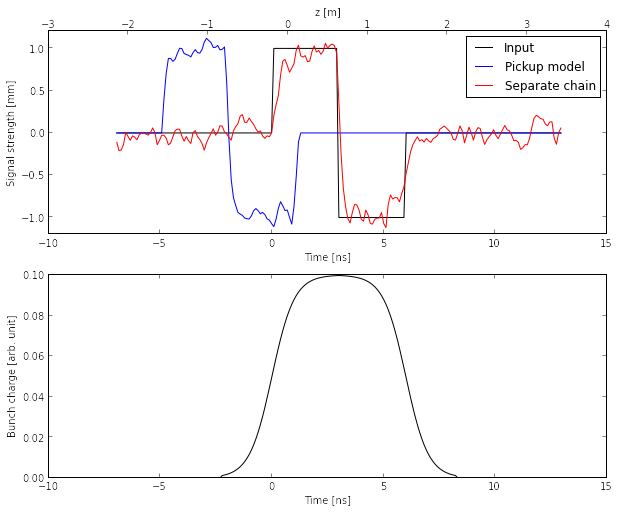

In [39]:
# CASE I:
# Compare signal processor chains by using a signal generator as a signal source

noise = 2e-4
f_c = 1e9
threshold = 2e-4

signal = SquareWaveImpulse(20e-9,6e-9,200,1e-3,5e-10)
#signal = SineStep(3e-9,1e9,100,1e-3,0.1e-9)

pickup_model = [
    processors.PickUp(noise, f_c, threshold),
    processors.Delay(-5e-9)
]

pickup_chain = [
    processors.ChargeWeighter(),
    processors.NoiseGenerator(noise,'absolute','normal'),
    processors.LowpassFilter(f_c)
]
compare_processor_chains(signal, pickup_model, pickup_chain,'Pickup model','Separate chain')

In [40]:
# CASE II:
# Compare signal processor chains by using the generated bunch as a signal source

noise = 0
f_c = 1e9

pickup_model = [
    processors.PickUp(noise, f_c)
]

pickup_chain = [
    processors.ChargeWeighter(),
    processors.NoiseGenerator(noise,'absolute','normal'),
    processors.LowpassFilter(f_c)
]

slice_set = bunch_ref.get_slices(slicer, statistics=True)
compare_processor_chains(slice_set, pickup_model, pickup_chain,'Pickup model','Separate chain')

TypeError: __init__() takes exactly 4 arguments (3 given)